# In this notebook, the following things are done for BRCA
* [Univarite CoxPH model for seleting significant features](#CoxPH)
* [Clustering for generating the gorups](#Clustering(Using-k-means-clustering-and-plot-it-based-PCA-features))
* [KM Plot generation and calculate logrank p-value](#KM-Plot-Generation-for-each-cluster-using-KaplanMeier-Filter)

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [51]:
from lifelines import CoxPHFitter 
import xenaPython as xena
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

In [4]:
from chart_studio import plotly
import plotly.graph_objs as go
from plotly import tools
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sb

In [5]:
CANCER = 'BRCA'
DATA_PATH = "/home/pdutta/Data/DGCCA/"
SUBTYPE_PATH= DATA_PATH + "TCGASubtype.20170308.tsv"
RESULT_PATH= "/home/pdutta/Github/Multiview_clustering_DGCCA/results/"
UNI_COX_MODEL_PATH = RESULT_PATH + 'UniCoX_embedding/{}/'.format(CANCER)

In [6]:
if not os.path.exists(UNI_COX_MODEL_PATH):
    os.makedirs(UNI_COX_MODEL_PATH)

In [7]:
id_mapping = pd.read_csv('/home/pdutta/Data/DGCCA/TCGA_{}/methyl_rnaseq_mirna_minmax_idmapping.tsv'.format(CANCER), sep='\t')

### Get the final embedding which is obtained from DGCCA

In [8]:
b = np.load('/home/pdutta/DGCCA/results/final_embeddings/final_embedding.npz')
embedding = b['arr_0']
df_embedding = pd.DataFrame(embedding)
df_embedding.index = id_mapping['sample']
df_embedding = df_embedding.rename(columns={k:'DGCCA_'+str(k+1) for k in df_embedding.columns})

In [9]:
df_embedding.head()

,DGCCA_1,DGCCA_2,DGCCA_3,DGCCA_4,DGCCA_5,DGCCA_6,DGCCA_7,DGCCA_8,DGCCA_9,DGCCA_10,...,DGCCA_91,DGCCA_92,DGCCA_93,DGCCA_94,DGCCA_95,DGCCA_96,DGCCA_97,DGCCA_98,DGCCA_99,DGCCA_100
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,-0.004126,-0.035931,-0.032696,-0.025678,-0.021700,0.018754,-0.027951,0.012279,0.033695,-0.040868,...,-0.043569,0.022437,-0.047810,0.033969,-0.023905,-0.012130,0.020938,0.002392,-0.010160,-0.002056
TCGA-3C-AALI-01,-0.008898,0.025296,0.029914,0.044020,0.007205,-0.002852,0.038143,-0.016290,-0.009044,0.023114,...,0.048611,-0.046596,0.028669,-0.026599,0.028161,0.052060,-0.000820,-0.029596,0.002734,0.025199
TCGA-3C-AALJ-01,0.020419,0.039209,0.016396,0.028215,0.033622,-0.009417,0.028166,-0.007988,-0.026179,0.033291,...,0.027299,-0.021551,0.013496,-0.000868,0.014953,0.020744,0.032510,0.033533,0.015098,0.018189
TCGA-3C-AALK-01,-0.037579,0.016135,0.016024,0.008897,0.016985,0.053724,0.007900,-0.079415,0.027272,0.009119,...,-0.024717,-0.009245,-0.007640,-0.051472,-0.007272,-0.009949,-0.009588,-0.030570,0.011992,0.014603
TCGA-4H-AAAK-01,0.019180,0.036924,0.059027,0.063696,0.059049,-0.018866,0.052302,-0.006420,-0.069070,0.066930,...,0.038438,-0.035251,0.032178,-0.054525,0.003943,0.029440,0.022896,0.013860,0.007753,0.001339


### Get the survival file and generate the dataframe

In [10]:
host = xena.PUBLIC_HUBS['tcgaHub']
dataset = "survival/BRCA_survival.txt"

In [11]:
samples = xena.dataset_samples (host, dataset, None)
features = xena.dataset_field(host, dataset)
features

['DFI',
 'DFI.time',
 'DSS',
 'DSS.time',
 'OS',
 'OS.time',
 'PFI',
 'PFI.time',
 'Redaction',
 '_PATIENT',
 'sampleID']

In [12]:
[position, [status,time]] = xena.dataset_probe_values(host, dataset, samples, ['OS','OS.time'])
df_status = pd.DataFrame(list(zip(samples, time, status)), columns = ['sample','time', 'status'])
df_status = df_status.set_index('sample')

In [13]:
print(df_status.shape, df_embedding.shape)
df_merge = pd.merge(df_embedding, df_status, left_index=True, right_index=True)
df_merge = df_merge.dropna(how='any',axis=0) 
print(df_merge.head())
print(df_merge.shape)
print(df_merge.groupby(['status']).size())

(1236, 2) (1233, 100)
                  DGCCA_1   DGCCA_2   DGCCA_3   DGCCA_4   DGCCA_5   DGCCA_6  \
sample                                                                        
TCGA-3C-AAAU-01 -0.004126 -0.035931 -0.032696 -0.025678 -0.021700  0.018754   
TCGA-3C-AALI-01 -0.008898  0.025296  0.029914  0.044020  0.007205 -0.002852   
TCGA-3C-AALJ-01  0.020419  0.039209  0.016396  0.028215  0.033622 -0.009417   
TCGA-3C-AALK-01 -0.037579  0.016135  0.016024  0.008897  0.016985  0.053724   
TCGA-4H-AAAK-01  0.019180  0.036924  0.059027  0.063696  0.059049 -0.018866   

                  DGCCA_7   DGCCA_8   DGCCA_9  DGCCA_10  ...  DGCCA_93  \
sample                                                   ...             
TCGA-3C-AAAU-01 -0.027951  0.012279  0.033695 -0.040868  ... -0.047810   
TCGA-3C-AALI-01  0.038143 -0.016290 -0.009044  0.023114  ...  0.028669   
TCGA-3C-AALJ-01  0.028166 -0.007988 -0.026179  0.033291  ...  0.013496   
TCGA-3C-AALK-01  0.007900 -0.079415  0.027272  0.00911

<a id='CoxPH'></a>
### Univariate CoxPH model

In [14]:
df_merge = df_merge.replace('NaN', np.nan)
df_merge = df_merge.dropna()
df_merge

,DGCCA_1,DGCCA_2,DGCCA_3,DGCCA_4,DGCCA_5,DGCCA_6,DGCCA_7,DGCCA_8,DGCCA_9,DGCCA_10,...,DGCCA_93,DGCCA_94,DGCCA_95,DGCCA_96,DGCCA_97,DGCCA_98,DGCCA_99,DGCCA_100,time,status
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,-0.004126,-0.035931,-0.032696,-0.025678,-0.021700,0.018754,-0.027951,0.012279,0.033695,-0.040868,...,-0.047810,0.033969,-0.023905,-0.012130,0.020938,0.002392,-0.010160,-0.002056,4047.0,0
TCGA-3C-AALI-01,-0.008898,0.025296,0.029914,0.044020,0.007205,-0.002852,0.038143,-0.016290,-0.009044,0.023114,...,0.028669,-0.026599,0.028161,0.052060,-0.000820,-0.029596,0.002734,0.025199,4005.0,0
TCGA-3C-AALJ-01,0.020419,0.039209,0.016396,0.028215,0.033622,-0.009417,0.028166,-0.007988,-0.026179,0.033291,...,0.013496,-0.000868,0.014953,0.020744,0.032510,0.033533,0.015098,0.018189,1474.0,0
TCGA-3C-AALK-01,-0.037579,0.016135,0.016024,0.008897,0.016985,0.053724,0.007900,-0.079415,0.027272,0.009119,...,-0.007640,-0.051472,-0.007272,-0.009949,-0.009588,-0.030570,0.011992,0.014603,1448.0,0
TCGA-4H-AAAK-01,0.019180,0.036924,0.059027,0.063696,0.059049,-0.018866,0.052302,-0.006420,-0.069070,0.066930,...,0.032178,-0.054525,0.003943,0.029440,0.022896,0.013860,0.007753,0.001339,348.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.100052,-0.018928,0.001939,-0.003604,-0.006981,-0.004244,-0.047272,-0.036211,-0.038970,-0.016771,...,0.016633,0.014361,0.030201,0.015915,0.002382,0.028020,-0.030430,-0.001384,883.0,0
TCGA-XX-A899-01,-0.026961,-0.075412,-0.004517,-0.009904,0.002015,0.018768,-0.013579,-0.038255,-0.015936,-0.076893,...,-0.035561,-0.064939,0.022823,0.008223,0.016908,0.009564,0.019887,-0.006655,467.0,0
TCGA-XX-A89A-01,-0.019171,0.084806,-0.011131,-0.014295,-0.007510,-0.011828,-0.053661,0.067523,-0.014301,-0.071886,...,-0.000091,0.008491,-0.011258,0.002196,0.014359,0.006545,0.004294,0.002638,488.0,0


In [15]:
df_uni_cox_result= pd.DataFrame(columns=['feature_name', 'coefficient', 'coef_lower_95%','coef_upper_95%','z-value','p-value','-log2(p)','partial_AIC','C-index'])
temp = 0
for i in df_merge.columns[:-2]:
    data_r= df_merge.loc[:,[i,'time', 'status']]
    cph = CoxPHFitter()   
    cph.fit(data_r, 'time', event_col='status') 
    df_uni_cox_result.loc[temp, ['feature_name']] = i
    df_uni_cox_result.loc[temp, ['coefficient']] = cph.summary.loc[i]['coef']
    df_uni_cox_result.loc[temp, ['coef_lower_95%']] = cph.summary.loc[i]['coef lower 95%']
    df_uni_cox_result.loc[temp, ['coef_upper_95%']] = cph.summary.loc[i]['coef upper 95%']
    df_uni_cox_result.loc[temp, ['z-value']] = cph.summary.loc[i]['z']
    df_uni_cox_result.loc[temp, ['p-value']] = cph.summary.loc[i]['p']
    df_uni_cox_result.loc[temp, ['-log2(p)']] = cph.summary.loc[i]['-log2(p)']
    df_uni_cox_result.loc[temp, ['partial_AIC']] = cph.AIC_partial_
    df_uni_cox_result.loc[temp, ['C-index']] = cph.concordance_index_
    temp=temp +1

In [16]:
df_uni_cox_result

,feature_name,coefficient,coef_lower_95%,coef_upper_95%,z-value,p-value,-log2(p),partial_AIC,C-index
0,DGCCA_1,2.342754,-1.38061,6.066118,1.233216,0.217495,2.200946,2335.346245,0.520277
1,DGCCA_2,2.992968,-0.899359,6.885295,1.507096,0.131786,2.923729,2334.615299,0.52396
2,DGCCA_3,0.413596,-3.299916,4.127109,0.218293,0.827201,0.27369,2336.823911,0.555654
3,DGCCA_4,0.398604,-3.384418,4.181626,0.206515,0.836389,0.257754,2336.828935,0.490513
4,DGCCA_5,1.890722,-1.826848,5.608292,0.99682,0.318852,1.649041,2335.888701,0.518658
...,...,...,...,...,...,...,...,...,...
95,DGCCA_96,-2.105939,-5.849736,1.637859,-1.102507,0.270241,1.88768,2335.66678,0.513876
96,DGCCA_97,3.105282,-0.608515,6.819079,1.638819,0.101251,3.303993,2334.166985,0.525059
97,DGCCA_98,2.938512,-0.860562,6.737586,1.515995,0.129521,2.948747,2334.597793,0.526252
98,DGCCA_99,2.089881,-0.992108,5.17187,1.329041,0.183834,2.443522,2335.175682,0.523275


In [17]:
df_uni_cox_result.to_csv(UNI_COX_MODEL_PATH+"UniVaR_CoXPh_result.csv", index=False)

In [18]:
df_sig_feature = df_uni_cox_result.loc[(df_uni_cox_result['p-value'] < 0.05)].reset_index(drop=True)
df_sig_feature

,feature_name,coefficient,coef_lower_95%,coef_upper_95%,z-value,p-value,-log2(p),partial_AIC,C-index
0,DGCCA_16,4.81916,1.125528,8.512793,2.557206,0.010552,6.566386,2330.494725,0.547665
1,DGCCA_28,4.064168,0.502702,7.625635,2.236613,0.025312,5.304057,2331.912807,0.554149
2,DGCCA_31,-3.672432,-7.257192,-0.087671,-2.007898,0.044654,4.485063,2332.850316,0.54114
3,DGCCA_38,3.821883,0.379063,7.264703,2.175761,0.029573,5.079568,2332.189699,0.5708
4,DGCCA_71,-3.98258,-7.625145,-0.340015,-2.142917,0.03212,4.960394,2332.262199,0.511739
5,DGCCA_82,-5.708858,-9.766076,-1.651641,-2.75784,0.005818,7.425145,2329.188645,0.553786
6,DGCCA_88,3.691822,0.055335,7.328309,1.989788,0.046614,4.423084,2332.988425,0.543681


In [19]:
important_features = list(df_sig_feature['feature_name'])
all_column_values = important_features + ['time','status']
df_survival = df_merge[all_column_values]
df_clustering = df_merge[important_features]

In [20]:
df_survival

,DGCCA_16,DGCCA_28,DGCCA_31,DGCCA_38,DGCCA_71,DGCCA_82,DGCCA_88,time,status
sample,,,,,,,,,
TCGA-3C-AAAU-01,0.026542,-0.043020,0.024133,-0.059654,-0.043187,-0.018743,0.025707,4047.0,0
TCGA-3C-AALI-01,-0.012684,0.030722,0.011348,0.019268,0.069069,0.054442,-0.012822,4005.0,0
TCGA-3C-AALJ-01,-0.033559,0.007959,-0.020635,0.044554,0.018807,0.024550,-0.042716,1474.0,0
TCGA-3C-AALK-01,-0.012949,-0.010193,0.006851,-0.005828,0.011448,-0.001263,0.002126,1448.0,0
TCGA-4H-AAAK-01,-0.077925,0.049827,0.003462,0.043760,0.040329,0.031582,-0.024287,348.0,0
...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,-0.013361,0.032249,-0.069677,0.018271,0.016160,-0.057800,0.114186,883.0,0
TCGA-XX-A899-01,0.022087,0.070231,0.182214,0.025570,0.007641,-0.175813,-0.000364,467.0,0
TCGA-XX-A89A-01,-0.038190,-0.025289,0.169351,-0.031165,-0.049530,-0.003418,0.091111,488.0,0


In [21]:
df_clustering.to_csv(UNI_COX_MODEL_PATH+"UniVaR_cluster_feature.csv")

In [22]:
df_survival.to_csv(UNI_COX_MODEL_PATH+"UniVaR_survival_feature.csv")

## Clustering(Using k-means clustering and plot it based PCA features)

In [23]:
pca = PCA(n_components=3)
embedding_pca = pca.fit_transform(df_clustering)
#print(embedding_pca)
df_clustering['PCA_1'] = embedding_pca[:,0]
df_clustering['PCA_2'] = embedding_pca[:,1]
df_clustering

,DGCCA_16,DGCCA_28,DGCCA_31,DGCCA_38,DGCCA_71,DGCCA_82,DGCCA_88,PCA_1,PCA_2
sample,,,,,,,,,
TCGA-3C-AAAU-01,0.026542,-0.043020,0.024133,-0.059654,-0.043187,-0.018743,0.025707,0.039205,-0.070715
TCGA-3C-AALI-01,-0.012684,0.030722,0.011348,0.019268,0.069069,0.054442,-0.012822,0.012231,0.071557
TCGA-3C-AALJ-01,-0.033559,0.007959,-0.020635,0.044554,0.018807,0.024550,-0.042716,-0.030521,0.057637
TCGA-3C-AALK-01,-0.012949,-0.010193,0.006851,-0.005828,0.011448,-0.001263,0.002126,-0.000408,-0.006201
TCGA-4H-AAAK-01,-0.077925,0.049827,0.003462,0.043760,0.040329,0.031582,-0.024287,-0.059587,0.069673
...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,-0.013361,0.032249,-0.069677,0.018271,0.016160,-0.057800,0.114186,-0.044784,-0.036907
TCGA-XX-A899-01,0.022087,0.070231,0.182214,0.025570,0.007641,-0.175813,-0.000364,-0.094849,-0.133609
TCGA-XX-A89A-01,-0.038190,-0.025289,0.169351,-0.031165,-0.049530,-0.003418,0.091111,-0.035089,-0.077772


In [24]:
df_clustering.iloc[:,-2]

sample
TCGA-3C-AAAU-01    0.039205
TCGA-3C-AALI-01    0.012231
TCGA-3C-AALJ-01   -0.030521
TCGA-3C-AALK-01   -0.000408
TCGA-4H-AAAK-01   -0.059587
                     ...   
TCGA-WT-AB44-01   -0.044784
TCGA-XX-A899-01   -0.094849
TCGA-XX-A89A-01   -0.035089
TCGA-Z7-A8R5-01    0.023564
TCGA-Z7-A8R6-01    0.015605
Name: PCA_1, Length: 1229, dtype: float32

In [25]:
clustering_data = df_clustering.iloc[:,:-2]
clustering_data

,DGCCA_16,DGCCA_28,DGCCA_31,DGCCA_38,DGCCA_71,DGCCA_82,DGCCA_88
sample,,,,,,,
TCGA-3C-AAAU-01,0.026542,-0.043020,0.024133,-0.059654,-0.043187,-0.018743,0.025707
TCGA-3C-AALI-01,-0.012684,0.030722,0.011348,0.019268,0.069069,0.054442,-0.012822
TCGA-3C-AALJ-01,-0.033559,0.007959,-0.020635,0.044554,0.018807,0.024550,-0.042716
TCGA-3C-AALK-01,-0.012949,-0.010193,0.006851,-0.005828,0.011448,-0.001263,0.002126
TCGA-4H-AAAK-01,-0.077925,0.049827,0.003462,0.043760,0.040329,0.031582,-0.024287
...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,-0.013361,0.032249,-0.069677,0.018271,0.016160,-0.057800,0.114186
TCGA-XX-A899-01,0.022087,0.070231,0.182214,0.025570,0.007641,-0.175813,-0.000364
TCGA-XX-A89A-01,-0.038190,-0.025289,0.169351,-0.031165,-0.049530,-0.003418,0.091111


k = 2, silhouette width = 0.09143487364053726, calinski-harabasz score = 114.95680709025189
k = 3, silhouette width = 0.08502776175737381, calinski-harabasz score = 105.69469615469924
k = 4, silhouette width = 0.08394793421030045, calinski-harabasz score = 96.77432366446955
k = 5, silhouette width = 0.08548256754875183, calinski-harabasz score = 91.96105523236712
k = 6, silhouette width = 0.0833570584654808, calinski-harabasz score = 88.30706102549263
k = 7, silhouette width = 0.08685876429080963, calinski-harabasz score = 84.51986402976021
k = 8, silhouette width = 0.08623190224170685, calinski-harabasz score = 83.20898993768803
k = 9, silhouette width = 0.08405372500419617, calinski-harabasz score = 78.35182696904351


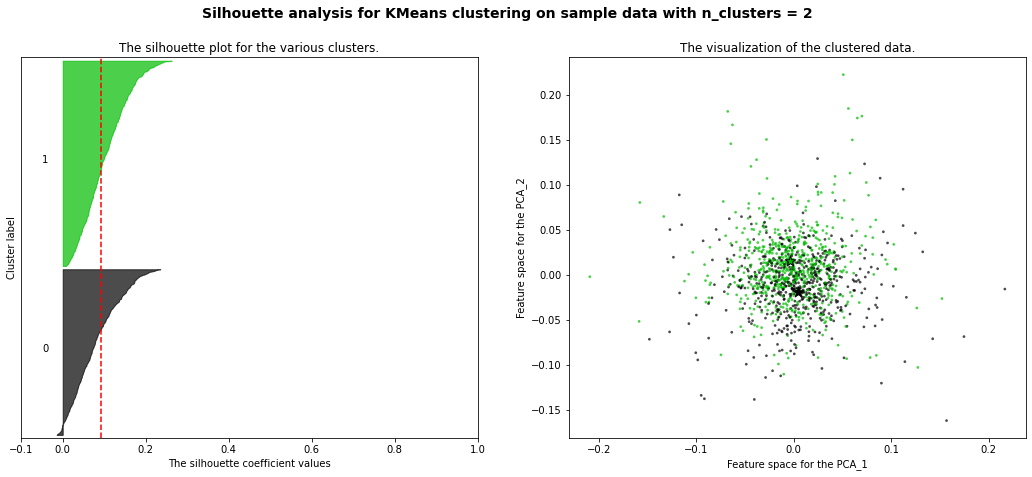

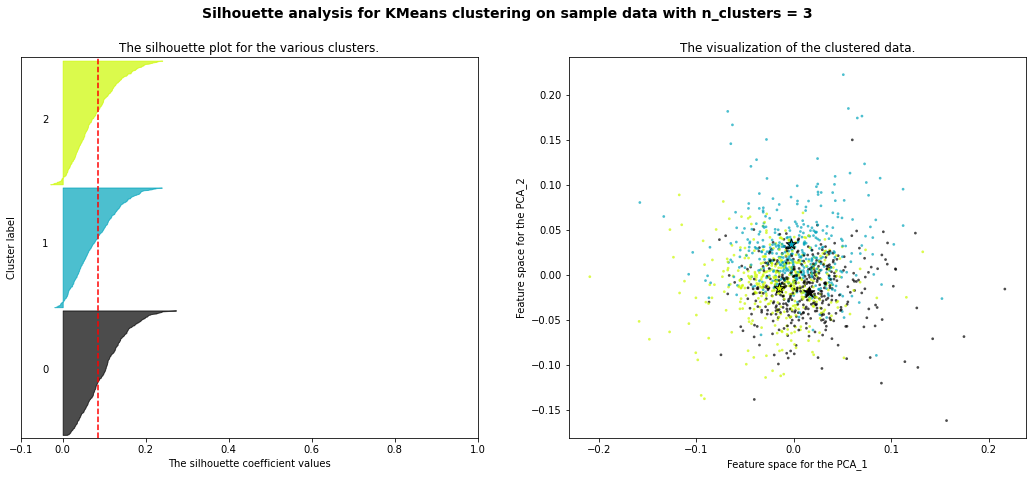

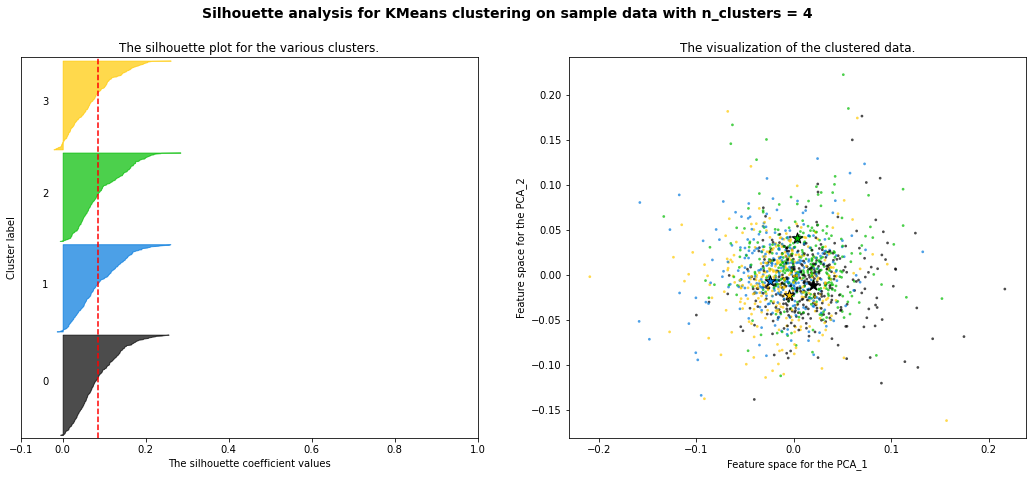

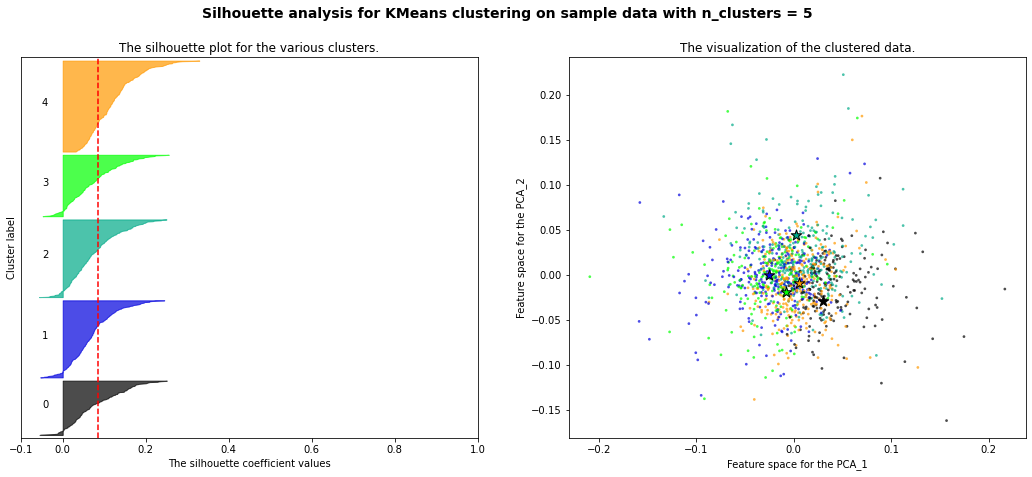

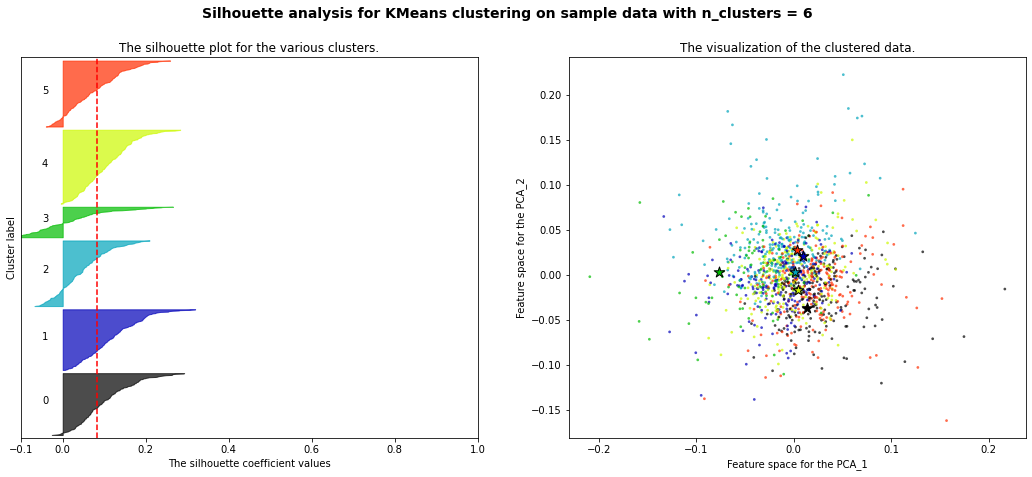

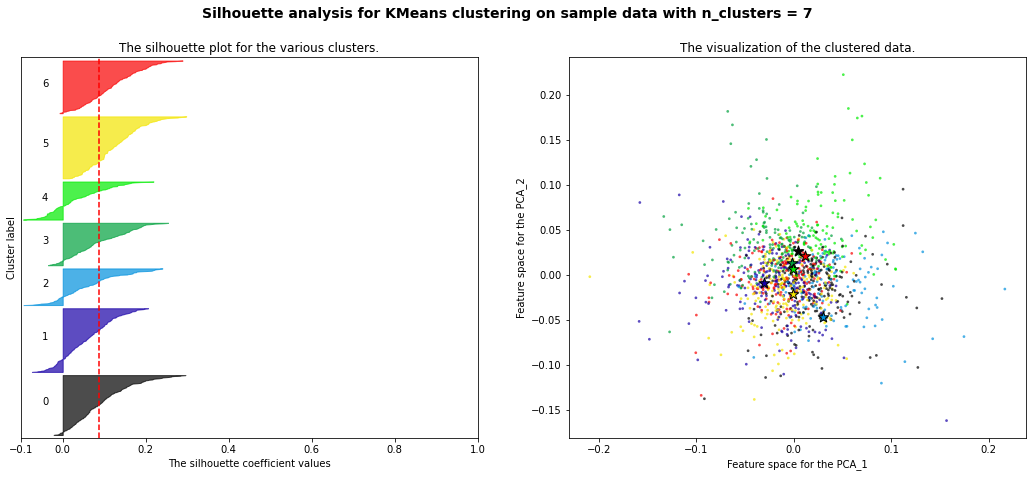

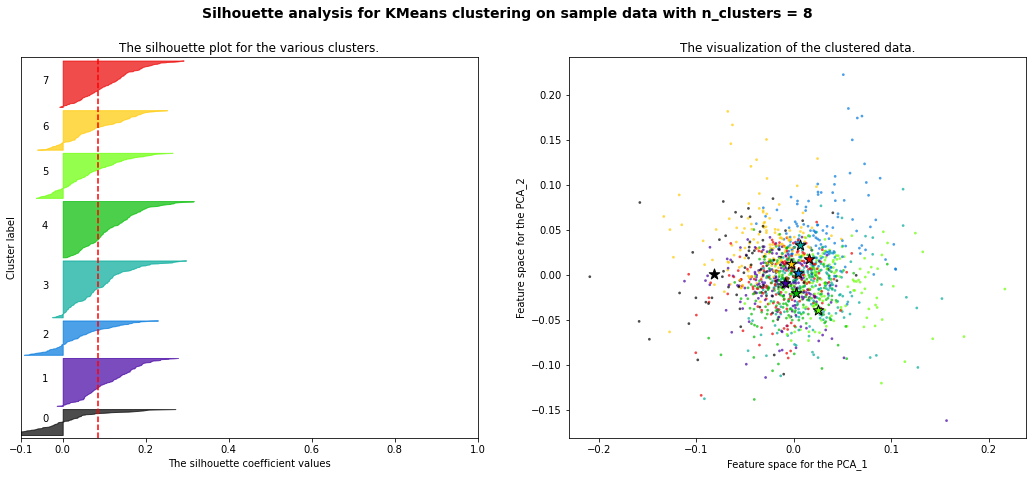

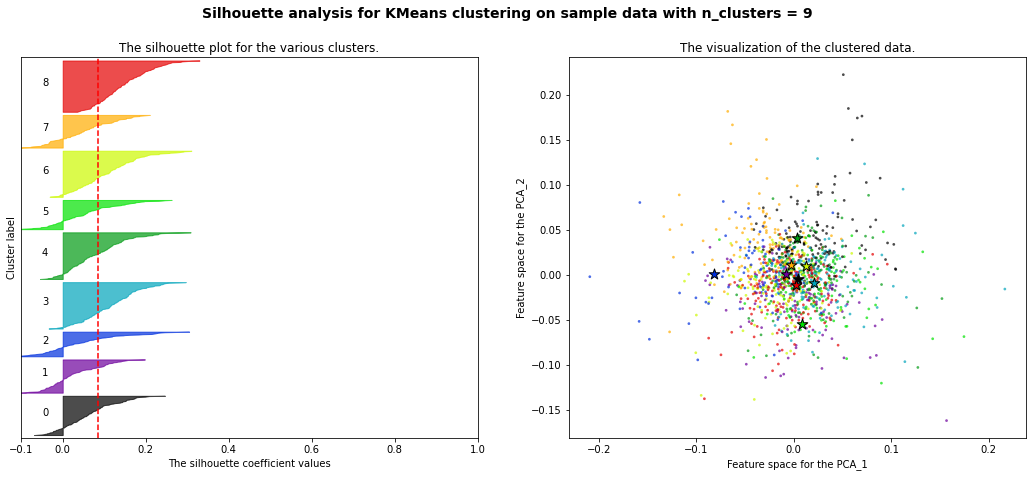

In [26]:
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,n_init=100,max_iter=2000,random_state=123)
    kmeans.fit(clustering_data)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    sil_score = metrics.silhouette_score(clustering_data, labels)
    ch_score = metrics.calinski_harabasz_score(clustering_data, labels)
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}'.format(k,sil_score,ch_score))
    df_survival[str(k)+'_cluster_result'] = labels
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    

    # The 1st subplot is the silhouette plot, The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1], /
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(clustering_data) + (k + 1) * 10])



    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(clustering_data, labels)
    
    y_lower = 10
    color_list = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        color_list.append(color)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(df_clustering.iloc[:,-2], df_clustering.iloc[:,-1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    for i in range(len(centroids)):
        ax2.scatter(centroids[i][0], centroids[i][1], color = color_list[i], edgecolor='black',s = 124, marker='*' )
    #plot.show()

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the PCA_1")
    ax2.set_ylabel("Feature space for the PCA_2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

## KM Plot Generation for each cluster using KaplanMeier Filter

In [27]:
kmf = KaplanMeierFitter()

In [28]:
df_kmf = df_survival.iloc[:,-10:]
df_kmf

,time,status,2_cluster_result,3_cluster_result,4_cluster_result,5_cluster_result,6_cluster_result,7_cluster_result,8_cluster_result,9_cluster_result
sample,,,,,,,,,,
TCGA-3C-AAAU-01,4047.0,0,0,0,0,4,0,1,1,1
TCGA-3C-AALI-01,4005.0,0,1,1,1,2,2,4,2,4
TCGA-3C-AALJ-01,1474.0,0,1,1,1,3,2,3,6,7
TCGA-3C-AALK-01,1448.0,0,0,2,1,4,0,1,4,8
TCGA-4H-AAAK-01,348.0,0,1,1,1,2,3,3,0,2
...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,883.0,0,1,0,0,4,4,5,4,8
TCGA-XX-A899-01,467.0,0,0,2,1,1,1,6,7,6
TCGA-XX-A89A-01,488.0,0,0,0,1,1,1,6,7,6


In [94]:
T = df_kmf["time"]
E = df_kmf["status"]

%^ 0.036533224763505415
%^ 0.06136928759799437
%^ 0.02641889446440357
%^ 0.003427117118517953
%^ 0.005012146408351262
%^ 0.03313300794481372
%^ 0.09587308338197532
%^ 0.0028932459303070996


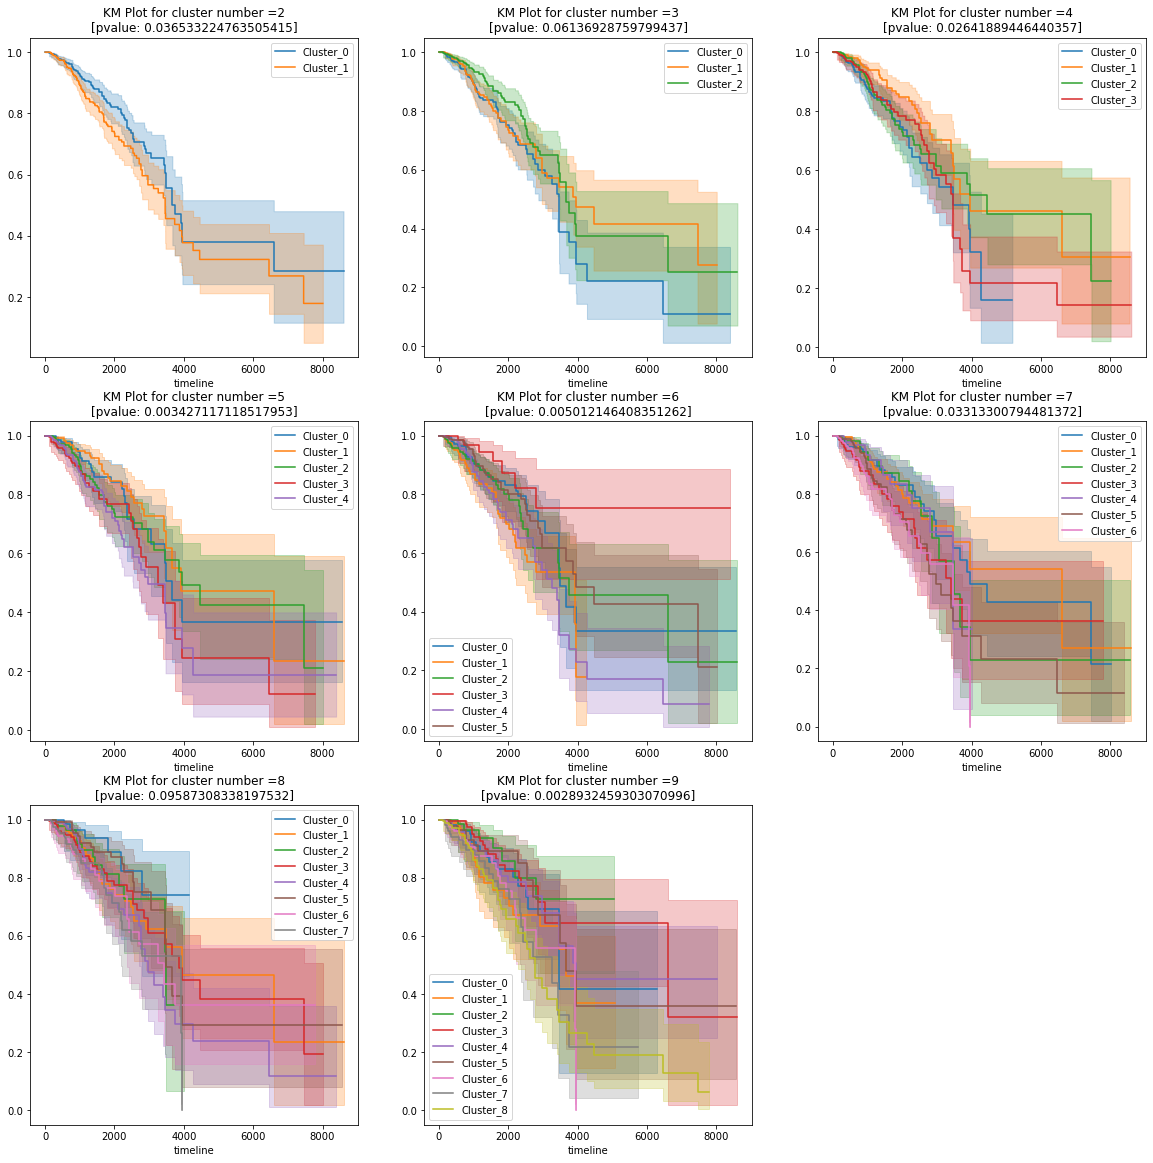

In [60]:
plt.figure(figsize=(20,20))
cluster_number = 2
for k in range(2,10):
    ax = plt.subplot(3, 3, k - 1)
    
    for i in range(k):
        #t = np.linspace(0, 50, 51)
        col_name = str(k)+'_cluster_result'
        T = df_kmf[df_kmf[col_name]==i]['time'].to_list()
        E = df_kmf[df_kmf[col_name]==i]['status'].to_list()
        kmf.fit(T, E, label="Cluster_"+str(i))
        ax = kmf.plot_survival_function(ax=ax)
    result = multivariate_logrank_test(df_kmf['time'], df_kmf[col_name], df_kmf['status'])
    #print("##",result.test_statistic)
    print(k,result.p_value)
    #print("IO",result.print_summary())
    plt.title("KM Plot for cluster number ="+str(k)+"\n[pvalue: {}]".format(result.p_value));